In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [1]:
from utils.dataloader import make_datapath_list, DataTransform

#ファイルパスリストを作成
rootpath="./data/VOCdevkit/VOC2012/"
train_img_list,train_anno_list,val_img_list,val_anno_list=make_datapath_list(rootpath=rootpath)

#後ほどアノテーション画像のみ使用する

In [4]:
from utils.pspnet import PSPNet

net=PSPNet(n_classes=21)

#学習済みパラメタをロード
state_dict=torch.load("./weights/pspnet_finetuning50_30pth",map_location={'cuda:0':'cpu'})
net.load_state_dict(state_dict)

print("ネットワーク設定完了：学習済みの重みをロードしました")

ネットワーク設定完了：学習済みの重みをロードしました


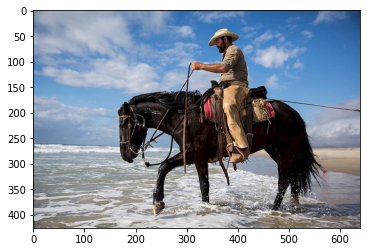

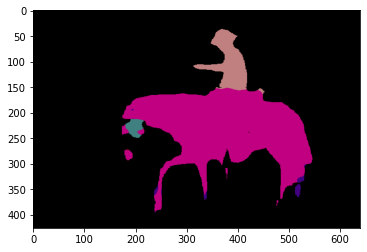

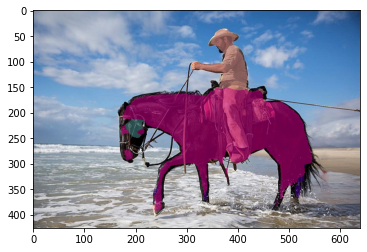

In [8]:
#1. 元画像の表示
image_file_path="./data/cowboy-757575_640.jpg"
img=Image.open(image_file_path)
img_width,img_height=img.size
plt.imshow(img)
plt.show()

#2. 前処理クラスの作成
color_mean=(0.485,0.456,0.406)
color_std=(0.229,0.224,0.225)
transform=DataTransform(input_size=475,color_mean=color_mean,color_std=color_std)

#3. 前処理
#適当なアノテーション画像を用意し，さらにカラーパレットの情報を抜き出す
anno_file_path=val_anno_list[0]
anno_class_img=Image.open(anno_file_path)
p_palette=anno_class_img.getpalette() #パレット情報256*3の要素を持つ
phase="val"
img,anno_class_img=transform(phase,img,anno_class_img)

#4. PSPNetで推論
net.eval()
x=img.unsqueeze(0) #ミニバッチ化torch.Size([1,3,475,475])
outputs=net(x)
y=outputs[0]

#5. PSPNetの出力から最大クラスを求め，カラーパレット形式にし，画像サイズをもとに戻す
y=y[0].detach().numpy()
y=np.argmax(y,axis=0)
anno_class_img=Image.fromarray(np.uint8(y),mode='P')
anno_class_img=anno_class_img.resize((img_width,img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette) #パレット情報をもたせる
plt.imshow(anno_class_img)
plt.show()

#6. 画像を透過させて重ねる
trans_img=Image.new('RGBA',anno_class_img.size,(0,0,0,0))
anno_class_img=anno_class_img.convert('RGBA') #カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        #推論結果画像のピクセルデータを取得
        pixel=anno_class_img.getpixel((x,y))
        r,g,b,a=pixel
        
        #(0,0,0)の背景ならそのままにして透過させる
        if pixel[0]==0 and pixel[1]==0 and pixel[2]==0:
            continue
        else:
            #それ以外は用意した画像にピクセルを書き込む
            trans_img.putpixel((x,y),(r,g,b,150))
            #150は透過度の大きさ
            
img=Image.open(image_file_path)
result=Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()